<a href="https://colab.research.google.com/github/pastrop/kaggle/blob/master/Emails_Processing_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Email Analysis Notebook

# Email Parsing & Initial Processing

In [1]:
#Imports
import pandas as pd
import numpy as np
import re
import io
from pathlib import Path

In [44]:
# file upload while using Google Colab
from google.colab import files
uploaded = files.upload()

Saving all_documents.zip to all_documents.zip


In [ ]:
# files unzipping
!unzip all_documents.zip

In [ ]:
with open('./contacts/1462.copy', 'r',encoding='utf-8-sig') as file:
    data = file.read()

In [ ]:
#paths = Path('/content/contacts').glob('**/[!.]*')
paths = Path('/content/all_documents').glob('**/[!.]*')
msg = []
for path in paths:
    # because path is object not string
    path_in_str = str(path)
    # Do thing with the path
    print(path_in_str)
    with io.open(path, 'r', errors='ignore') as file:
      msg.append(file.read())

In [ ]:
msg[:5]

In [53]:
#message processing
def parse_raw_message(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'to']
    for line in lines:
        if ':' not in line:
            if not re.findall(r"[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+", line) and \
            not re.findall(r"(\.com|\.org|IMAP|ESMTP|(EDT)|(ICT))", line): 
              message += line.strip()
              email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val+' '
    return email

def parse_into_emails(messages):
  emails = [parse_raw_message(message) for message in messages]
  return {'body': map_to_list(emails, 'body'), 
          #'to': map_to_list(emails, 'to'), 
          'from': map_to_list(emails, 'from')
          }

def map_to_list(dct, key):
  tmp = []
  for item in dct:
    tmp.append(item[key])
  return tmp 

In [ ]:
test = 

In [58]:
#test
res = parse_into_emails(msg)
# lst of labels for the Embedding Projector
labels = res['from']
#labels = [str(x)+str(y) for x,y in zip(res['from'], res['to'])] # str()  is just to make sure bcs the data is pretty dirty

In [28]:
#email_df = pd.DataFrame(res)

In [15]:
#text processing
import string
import nltk
#nltk.download('punkt')
#nltk.download('wordnet')
nltk.download('stopwords')
#from nltk.stem import WordNetLemmatizer
#wordnet_lemmatizer = WordNetLemmatizer()
#from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [59]:
#dealing with punctions while preventing word merging the words(people don't put blanks where they should...)
tmp = []
for item in res['body']:
  temp = item.translate(str.maketrans(',.', '  '))
  tmp.append(temp.translate(str.maketrans('', '', string.punctuation)))
res['body'] = tmp  

In [60]:
#exlude stop words
stop_words = stopwords.words('english')
#msgs_for_embedding = [w for w in res['body'] if not w in stop_words]

# Modelling & Analysis

**Clustering - Visual Analysis**

In [23]:
!pip install -q tensorflow-hub
import tensorflow_hub as hub

In [29]:
# data visualization:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [24]:
#using universal sentence encoder to get sentence encodings
#Load the Universal Sentence Encoder's TF Hub module
#param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" # Using DAN
print ("module {} loaded".format(module_url))
model = hub.load(module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [61]:
embedding_tuples = []
for item, label in zip(res['body'], labels):
  tmp = embed([item])[0].numpy(),label
  embedding_tuples.append(tmp)

In [30]:
# visualization code
def tsne_plot(emb):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    #print(sentences[0])
    #print(emb[0][0])
    for i in range(len(emb)):
        tokens.append(emb[i][0])
        labels.append(emb[i][1])
    
    tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    #Outputting all the embeddings
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
    plt.show()

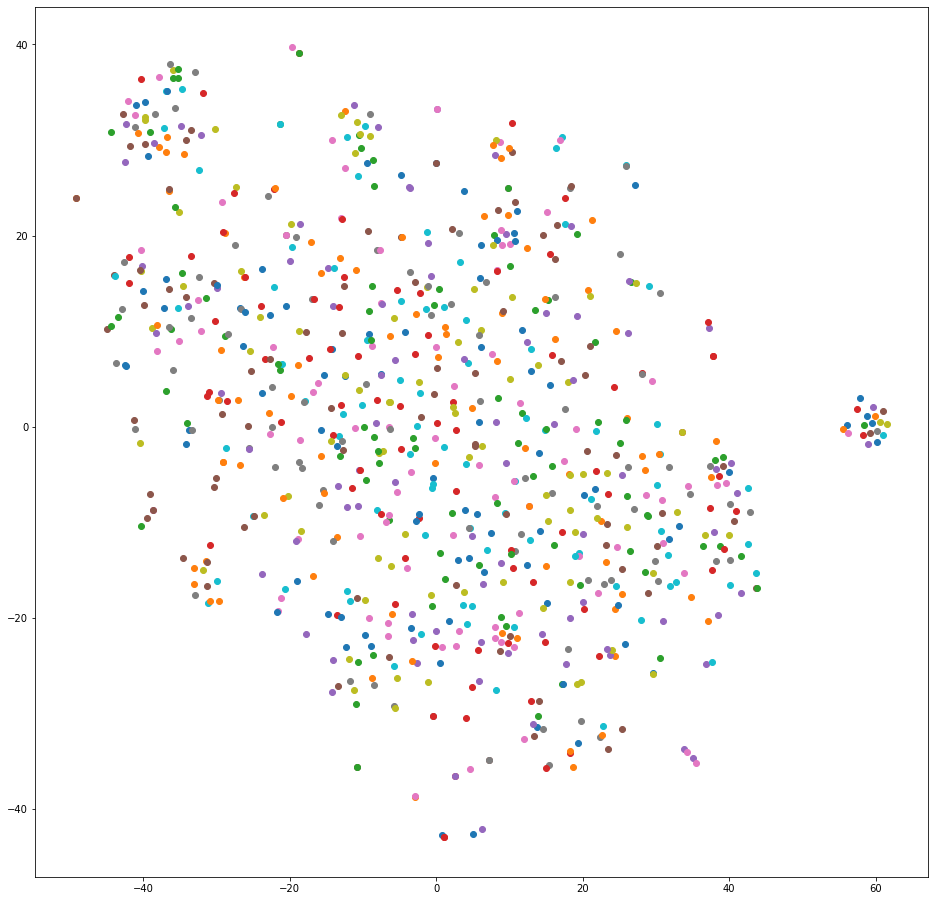

In [62]:
# The goal here is to see whether the data has any structure whatever
tsne_plot(embedding_tuples)

**Tensorflow Embedding Projector**

In [32]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
%load_ext tensorboard

In [40]:
import os
from tensorboard.plugins import projector
import tensorflow as tf

In [34]:
# Set up a logs directory, so Tensorboard knows where to look for files
log_dir='/logs/emb/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately line-by-line
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
  for label in embedding_tuples:
    f.write("{}\n".format(label[1]))

# Save embeddings in tsv file.

with open(os.path.join(log_dir, 'vectors.tsv'), "w") as f:
  for vec in embedding_tuples:
    tmp = '\t'.join(str(x) for x in vec[0])
    f.write("{}\n".format(tmp))

In [35]:
# all embeddings as numpy array of shape [n_words, embedding_size]
arrays = [vec[0] for vec in embedding_tuples]
embeddings_vectors = np.stack(arrays, axis=0)

In [36]:
# Save embeddings in TF variable.
emb = tf.Variable(embeddings_vectors, name='word_embeddings')

# Add ops to save and restore all the variables.
checkpoint = tf.train.Checkpoint(embedding=emb)

In [37]:
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

'/logs/emb/embedding.ckpt-1'

In [38]:
# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [42]:
!kill 285

In [ ]:
%tensorboard --logdir /logs/emb/
#Don't forget to select PROJECTOR from the TensorBoard dropdown

**LDA - Latent Dirichle Allocation**